In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.datasets import mnist
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv('../input/train.csv')
labels = train.iloc[:,0].values.astype('int32')
X_train = (train.iloc[:,1:].values).astype('float32')
X_test = (pd.read_csv('../input/test.csv').values).astype('float32')

#reshape into images
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

# one hot encoding
y_train = tf.keras.utils.to_categorical(labels) 


print("Check data")
print(labels)
print(X_train[0].shape)
print(y_train)

Check data
[1 0 1 ... 7 6 9]
(28, 28, 1)
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [3]:
# Load Data from Keras MNIST
(train_imagesRaw, train_labelsRaw), (test_imagesRaw, test_labelsRaw) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [4]:
#reshape into images
X_train_keras = train_imagesRaw.reshape(-1,28,28,1)
X_test_keras = test_imagesRaw.reshape(-1,28,28,1)

print("X_train_keras",X_train_keras.shape)
print("X_test_keras",X_test_keras.shape)

train_labels_keras = tf.keras.utils.to_categorical(train_labelsRaw)
test_labels_keras = tf.keras.utils.to_categorical(test_labelsRaw)
print("train_labels_keras ",train_labels_keras.shape)
print("test_labels_keras ", test_labels_keras.shape)

X_train_keras (60000, 28, 28, 1)
X_test_keras (10000, 28, 28, 1)
train_labels_keras  (60000, 10)
test_labels_keras  (10000, 10)


In [5]:
# merge datasets

train_images = np.concatenate((X_train_keras,X_train,X_test_keras), axis=0)
print("new Concatenated train_images ", train_images.shape)
print("_"*50)

train_labels = np.concatenate((train_labels_keras,y_train,test_labels_keras), axis=0)
print("new Concatenated train_labels ", train_labels.shape)

new Concatenated train_images  (112000, 28, 28, 1)
__________________________________________________
new Concatenated train_labels  (112000, 10)


([], <a list of 0 Text yticklabel objects>)

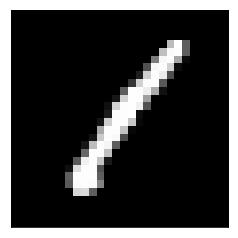

In [6]:
#visualize an image

fig = plt.figure()
plt.imshow(X_train[0][:,:,0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])



In [7]:
# super simple data pre process
scale = np.max(train_images)
train_images /= scale
X_test /= scale


#visualize scales

print("Max: {}".format(scale))



Max: 255.0


In [8]:
# Here we define the input and output layer sizes
input_size = train_images.shape
n_logits = train_labels.shape[1]

print("Input: {}".format(input_size))
print("Output: {}".format(n_logits))

Input: (112000, 28, 28, 1)
Output: 10


In [9]:
from keras.preprocessing.image import ImageDataGenerator

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 30
batch_size = 512
#get validation data

X_train, X_val, Y_train, Yval = train_test_split(train_images, train_labels, train_size = 0.90)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
# Here we define our keras model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu', input_shape=input_size[1:]))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(n_logits, activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)    

In [12]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Yval),
                              verbose = 1, steps_per_epoch=X_train.shape[0])

Epoch 1/30
197/197 [==============================] - 18s 90ms/step - loss: 0.5628 - acc: 0.8156 - val_loss: 0.0640 - val_acc: 0.9795
Epoch 2/30
197/197 [==============================] - 17s 85ms/step - loss: 0.1213 - acc: 0.9636 - val_loss: 0.0431 - val_acc: 0.9874
Epoch 3/30
197/197 [==============================] - 18s 90ms/step - loss: 0.0780 - acc: 0.9766 - val_loss: 0.0261 - val_acc: 0.9925
Epoch 4/30
197/197 [==============================] - 18s 92ms/step - loss: 0.0603 - acc: 0.9818 - val_loss: 0.0276 - val_acc: 0.9913
Epoch 5/30
197/197 [==============================] - 17s 86ms/step - loss: 0.0514 - acc: 0.9851 - val_loss: 0.0193 - val_acc: 0.9939
Epoch 6/30
197/197 [==============================] - 17s 84ms/step - loss: 0.0468 - acc: 0.9863 - val_loss: 0.0210 - val_acc: 0.9939
Epoch 7/30
197/197 [==============================] - 17s 85ms/step - loss: 0.0417 - acc: 0.9879 - val_loss: 0.0200 - val_acc: 0.9935
Epoch 8/30
197/197 [==============================] - 18s 89ms

In [13]:
# generate predictions
predictions = model.predict_classes(X_test, verbose=0)

print(predictions)
pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)), "Label": predictions}).to_csv("preds.csv", index=False, header=True)


[2 0 9 ... 3 9 2]
